**utils.py**

In [ ]:
!pip install pyDOE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!apt-get install python 3.5

In [ ]:
import os
import random
import math

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tabulate import tabulate
from pyDOE import lhs
import matplotlib.pyplot as plt

# utils.py

In [ ]:
import numpy as np
import cv2


# error message when image could not be read
IMAGE_NOT_READ = 'IMAGE_NOT_READ'

# error message when image is not colored while it should be
NOT_COLOR_IMAGE = 'NOT_COLOR_IMAGE'


def read_image(file_path, read_mode=cv2.IMREAD_COLOR):
    """
    Read image file with all preprocessing needed
    Args:
        file_path: absolute file_path of an image file
        read_mode: whether image reading mode is rgb, grayscale or somethin
    Returns:
        np.ndarray of the read image or None if couldn't read
    Raises:
        ValueError if image could not be read with message IMAGE_NOT_READ
    """
    # read image file in grayscale
    image = cv2.imread(file_path, read_mode)

    if image is None:
        raise ValueError(IMAGE_NOT_READ)
    else:
        return image


def ensure_color(image):
    """
    Ensure that an image is colored
    Args:
        image: image to be checked for
    Returns:
        nothing
    Raises:
        ValueError with message code if image is not colored
    """
    if len(image.shape) < 3:
        raise ValueError(NOT_COLOR_IMAGE)


def div0(a, b):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        q = np.true_divide(a, b)
        q[ ~ np.isfinite(q) ] = 0  # -inf inf NaN

    return q


def excess_green(image, scale = 2):
    """
    Compute excess green index for colored image
    Args:
        image: image to be converted
        scale: number to scale green channel of the image
    Returns:
        new image with excess green
    """

    ensure_color(image)

    bgr_sum = np.sum(image, axis=2)
    debug(bgr_sum, 'green bgr sum')

    blues = div0(image[:, :, 0], bgr_sum)
    greens = div0(image[:, :, 1], bgr_sum)
    reds = div0(image[:, :, 2], bgr_sum)

    index = scale * greens - (reds + blues)

    return index


def excess_red(image, scale=1.4):
    """
    Compute excess red index for colored image
    Args:
        image: image to be converted
        scale: number to scale red channel of the image
    Returns:
        new image with excess red
    """

    ensure_color(image)

    bgr_sum = np.sum(image, axis=2)

    blues = div0(image[:, :, 0], bgr_sum)
    greens = div0(image[:, :, 1], bgr_sum)
    reds = div0(image[:, :, 2], bgr_sum)

    index = scale * reds - greens

    return index


def index_diff(image, green_scale=2.0, red_scale=1.4):

    ensure_color(image)

    bgr_sum = np.sum(image, axis=2)

    blues = div0(image[:, :, 0], bgr_sum)
    greens = div0(image[:, :, 1], bgr_sum)
    reds = div0(image[:, :, 2], bgr_sum)

    green_index = green_scale * greens - (reds + blues)
    red_index = red_scale * reds - (greens)

    return green_index - red_index


def debug(value, name=None):
    if isinstance(value, np.ndarray):
        name = 'ndarray' if name is None else name

        print("{}: {}".format(name, value))
        print("{} shape: {}".format(name, value.shape))
    else:
        name = 'value' if name is None else name

        print("{} type: {}".format(name, type(value)))
        print("{}: {}".format(name, value))

# Dataset

In [ ]:
files = {
    "jpg1": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/1.jpg",
    "jpg2": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/7.jpg",
    "jpg3": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/48.jpg",
    "jpg4": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/1000.jpg",
    "jpg5": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/1001.jpg",
    "jpg6": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/1002.jpg",
    "jpg7": "/content/gdrive/MyDrive/input/all/raw/CoffeeDataset/1557.jpg",
    "jpg8": "/content/sample_data/571_marked.jpg",
}

# background marker.py

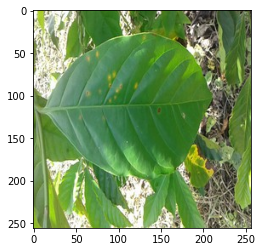

In [ ]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt

#from utils import *


# constants for filling holes mode
FILL = {
    'NO': 1,
    'FLOOD': 2,
    'THRESHOLD': 3,
    'MORPH': 4,
}


def remove_whites(image, marker):
    """
    Remove pixels resembling white from marker as background
    Args:
        image:
        marker: to be overloaded with white pixels to be removed
    Returns:
        nothing
    """
    # setup the white remover to process logical_and in place
    white_remover = np.full((image.shape[0], image.shape[1]), True)

    # below line same as: white_remover = np.logical_and(white_remover,  image[:, :, 0] > 200)
    white_remover[image[:, :, 0] <= 200] = False # blue channel

    # below line same as: white_remover = np.logical_and(white_remover,  image[:, :, 1] > 220)
    white_remover[image[:, :, 1] <= 220] = False  # green channel

    # below line same as: white_remover = np.logical_and(white_remover,  image[:, :, 2] > 200)
    white_remover[image[:, :, 2] <= 200] = False  # red channel

    # remove whites from marker
    marker[white_remover] = False


def remove_blacks(image, marker):
    """
    Remove pixels resembling black from marker as background
    Args:
        image:
        marker: to be overloaded with black pixels to be removed
    Returns:
        nothing
    """
    # setup the black remover to process logical_and in place
    black_remover = np.full((image.shape[0], image.shape[1]), True)

    # below line same as: black_remover = np.logical_and(black_remover,  image[:, :, 0] < 30)
    black_remover[image[:, :, 0] >= 30] = False  # blue channel

    # below line same as: black_remover = np.logical_and(black_remover,  image[:, :, 1] < 30)
    black_remover[image[:, :, 1] >= 30] = False  # green channel

    # below line same as: black_remover = np.logical_and(black_remover,  image[:, :, 2] < 30)
    black_remover[image[:, :, 2] >= 30] = False  # red channel

    # remove blacks from marker
    marker[black_remover] = False


def remove_blues(image, marker):
    """
    Remove pixels resembling blues better than green from marker as background
    Args:
        image:
        marker: to be overloaded with blue pixels to be removed
    Returns:
        nothing
    """
    # choose pixels that have higher blue than green
    blue_remover = image[:, :, 0] > image[:, :, 1]

    # remove blues from marker
    marker[blue_remover] = False


def color_index_marker(color_index_diff, marker):
    """
    Differentiate marker based on the difference of the color indexes
    Threshold below some number(found empirically based on testing on 5 photos,bad)
    If threshold number is getting less, more non-green image
     will be included and vice versa
    Args:
        color_index_diff: color index difference based on green index minus red index
        marker: marker to be updated
    Returns:
        nothing
    """
    marker[color_index_diff <= -0.05] = False


def texture_filter(image, marker, threshold=220, window=3):
    """
    Update marker based on texture of an image
    Args:
        image (ndarray of grayscale image):
        marker (ndarray size of image): marker to be updated
        threshold (number): minimum size of texture measurement(entropy) allowed
        window (int): window size of a square the texture computed from
    Returns: nothing
    """

    window = window - window//2 - 1
    for x in range(0, image.shape[0]):
        for y in range(0, image.shape[1]):
            # print('x y', x, y)
            # print('window', image[x:x + window, y:y + window])
            x_start = x - window if x < window else x
            y_start = y - window if y < window else y
            x_stop = x + window if x < image.shape[0] - window else image.shape[0]
            y_stop = y + window if y < image.shape[1] - window else image.shape[1]

            local_entropy = np.sum(image[x_start:x_stop, y_start:y_stop]
                                   * np.log(image[x_start:x_stop, y_start:y_stop] + 1e-07))
            # print('entropy', local_entropy)
            if local_entropy > threshold:
                marker[x, y] = False


def otsu_color_index(excess_green, excess_red):
    return cv2.threshold(excess_green - excess_red, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)


def generate_floodfill_mask(bin_image):
    """
    Generate a mask to remove backgrounds adjacent to image edge
    Args:
        bin_image (ndarray of grayscale image): image to remove backgrounds from
    Returns:
        a mask to backgrounds adjacent to image edge
    """
    y_mask = np.full(
        (bin_image.shape[0], bin_image.shape[1]), fill_value=255, dtype=np.uint8
    )
    x_mask = np.full(
        (bin_image.shape[0], bin_image.shape[1]), fill_value=255, dtype=np.uint8
    )

    xs, ys = bin_image.shape[0], bin_image.shape[1]

    for x in range(0, xs):
        item_indexes = np.where(bin_image[x,:] != 0)[0]
        # min_start_edge = ys
        # max_final_edge = 0
        if len(item_indexes):
            start_edge, final_edge = item_indexes[0], item_indexes[-1]
            x_mask[x, start_edge:final_edge] = 0
            # if start_edge < min_start_edge:
            #     min_start_edge = start_edge
            # if final_edge > max_final_edge:
            #     max_final_edge = final_edge

    for y in range(0, ys):
        item_indexes = np.where(bin_image[:,y] != 0)[0]
        if len(item_indexes):
            start_edge, final_edge = item_indexes[0], item_indexes[-1]

            y_mask[start_edge:final_edge, y] = 0
            # mask[:start_edge, y] = 255
            # mask[final_edge:, y] = 255

    return np.logical_or(x_mask, y_mask)


def select_largest_obj(img_bin, lab_val=255, fill_mode=FILL['FLOOD'],
                       smooth_boundary=False, kernel_size=15):
    """
    Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin (2D array): 2D numpy array of binary image.
        lab_val ([int]): integer value used for the label of the largest
                object. Default is 255.
        fill_mode (string {no,flood,threshold,morph}): hole filling techniques which are
            - no: no filling of holes
            - flood: floodfilling technique without removing image edge sharing holes
            - threshold: removing holes based on minimum size of hole to be removed
            - morph: closing morphological operation with some kernel size to remove holes
        smooth_boundary ([boolean]): whether smooth the boundary of the
                largest object using morphological opening or not. Default
                is false.
        kernel_size ([int]): the size of the kernel used for morphological
                operation. Default is 15.
    Returns:
        a binary image as a mask for the largest object.
    """

    # set up components
    n_labels, img_labeled, lab_stats, _ = \
        cv2.connectedComponentsWithStats(img_bin, connectivity=8, ltype=cv2.CV_32S)

    # find largest component label(label number works with labeled image because of +1)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1

    # create a mask that will only cover the largest component
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val

    if fill_mode == FILL['FLOOD']:
        # fill holes using opencv floodfill function

        # set up seedpoint(starting point) for floodfill
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])

        # copied image to be floodfill
        img_floodfill = largest_mask.copy()

        # create a mask to ignore what shouldn't be filled
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)

        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed,
                    newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.

        # get a mask to avoid filling non-holes that are adjacent to image edge
        non_holes_mask = generate_floodfill_mask(largest_mask)
        holes_mask = np.bitwise_and(holes_mask, np.bitwise_not(non_holes_mask))

        largest_mask = largest_mask + holes_mask

    elif fill_mode == FILL['MORPH']:
        # fill holes using closing morphology operation
        kernel_ = np.ones((50, 50), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_CLOSE,
                                        kernel_)
    elif fill_mode == FILL['THRESHOLD']:
        # fill background-holes based on hole size threshold
        # default hole size threshold is some percentage
        #   of size of the largest component(i.e leaf component)

        # invert to setup holes of background, sorry for the incovenience
        inv_img_bin = np.bitwise_not(largest_mask)

        # set up components
        inv_n_labels, inv_img_labeled, inv_lab_stats, _ = \
            cv2.connectedComponentsWithStats(inv_img_bin, connectivity=8, ltype=cv2.CV_32S)

        # find largest component label(label number works with labeled image because of +1)
        inv_largest_obj_lab = np.argmax(inv_lab_stats[1:, 4]) + 1

        # setup sizes and number of components
        inv_sizes = inv_lab_stats[1:, -1]
        sizes = lab_stats[1:, -1]
        inv_nb_components = inv_n_labels - 1

        # find the greater side of the image
        inv_max_side = np.amax(inv_img_labeled.shape)

        # set the minimum size of hole that is allowed to stay
        inv_min_size = int(0.3 * sizes[largest_obj_lab - 1]) # todo: specify good min size

        # generate the mask that allows holes greater than minimum size(weird)
        inv_mask = np.zeros((inv_img_labeled.shape), dtype=np.uint8)
        
        for inv_i in range(0, inv_nb_components):
            if inv_sizes[inv_i] >= inv_min_size:
                inv_mask[inv_img_labeled == inv_i + 1] = 255

        largest_mask = largest_mask + np.bitwise_not(inv_mask)

    if smooth_boundary:
        # smooth edge boundary
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN,
                                        kernel_)

    return largest_mask

def simple_test():

    image = read_image(files['jpg1'])

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(rgb_image)
    plt.show()

    # plt.imshow(cv2.cvtColor(excess_green(image), cv2.COLOR_BGR2RGB))
    # plt.show()
    #
    # plt.imshow(cv2.cvtColor(excess_red(image), cv2.COLOR_BGR2RGB))
    # plt.show()

if __name__ == '__main__':
    simple_test()

# otsu segmentation.py

In [ ]:
import cv2
import numpy as np

#from utils import *


def get_marker(image):
    """
    Get image marker to differentiate image background from foreground
    Args:
        image: image for which marker will be generated for
    Returns:
        ret_val:
        image_marker: marker
    """
    ret_val, image_marker = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return ret_val, image_marker

def apply_marker(image, marker, background = 0, inverse = True):
    """
    Apply marker on original image
    Args:
        image: original image to be masked
        marker: one hot encoded with 0 and 255
        background: grayscale value that will be set for background
        inverse: if boolean should be inversed to avoid giving background as
                 output rather than the leaf parts
    Returns:
        new_image that is masked with marker
    """

    # change marker to boolean index
    # mask = np.logical_not(marker.astype(bool))
    mask = marker.astype(bool)
    unique, counts = np.unique(mask, return_counts=True)
    unique_counts = dict(zip(unique, counts))
    # needs enhancment here, if difference is not much inverse
    # so that it will not segment the background rather than the leaf
    # 2000000 number should be enchanced(found empirically, with 8 images, bad)
    if inverse and unique_counts[True] - unique_counts[False] < 2000000:
        mask = np.logical_not(mask)

    new_image = image.copy()
    new_image[mask] = background
    new_image[~mask] = 255

    return new_image

def segment_with_otsu(image_file, background = 0):
    """
    Segment an image file using otsu thresholding
    Args:
        image_file: file path
        background: grayscale value to be set as background
    Returns:
        ret_val:
        segmented_image: in ndarray form
    """
    image = read_image(image_file, cv2.IMREAD_GRAYSCALE)
    
    ret_val, marker = get_marker(image)
    segmented_image = apply_marker(image, marker, background)

    return ret_val, segmented_image

# review.py

Enter image number: 5
plt showwing


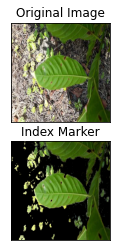

KeyboardInterrupt: ignored

In [ ]:
from matplotlib import pyplot as plt

#from utils import *
#from otsu_segmentation import *
#from background_marker import *


def show_review(original_image, image, image_title, hist_val=None, gray=False):
    if hist_val is None:
        plot_nums = 2
    else:
        plot_nums = 3

    cmap = 'gray' if gray else None
    # Original image plot
    original_image_show = original_image if gray else cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plot_index = 1
    plt.subplot(plot_nums, 1, plot_index), plt.imshow(original_image_show, cmap=cmap)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    # Histogram plot
    if hist_val is not None:
        plot_index += 1
        plt.subplot(plot_nums, 1, plot_index), plt.hist(original_image.ravel(), 256)
        plt.axvline(x=hist_val, color='r', linestyle='dashed', linewidth=2)
        plt.title(image_title + ' Histogram'), plt.xticks([]), plt.yticks([])

    # Processed image plot
    image_show = image if gray else cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plot_index += 1
    plt.subplot(plot_nums, 1, plot_index), plt.imshow(image_show, cmap=cmap)
    plt.title(image_title), plt.xticks([]), plt.yticks([])

    print('plt showwing')
    plt.show()

def review_marker(file_name):
    try:
        original_image = read_image(file_name)            
        ret_val, marker = get_marker(original_image)
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)  
        else:
            raise
    else:
        show_review(original_image, marker, 'Otsu Thresholding Marker', ret_val)


def review_segmentation(file_name):
    try:
        original_image = read_image(file_name)        
        ret_val, segmented_image = segment_with_otsu(file_name)
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, segmented_image, 'Otsu Thresholding', ret_val, gray=True)


def review_remove_whites(file_name):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        marker = np.full((original_image.shape[0], original_image.shape[1]), True)
        remove_whites(original_image, marker)

        image = original_image.copy()
        debug(image, 'image')
        debug(marker, 'marker')
        image[np.logical_not(marker)] = np.array([0, 0, 0])
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, image, 'Remove Reds')


def review_remove_blacks(file_name):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        marker = np.full((original_image.shape[0], original_image.shape[1]), True)
        remove_blacks(original_image, marker)

        image = original_image.copy()
        image[np.logical_not(marker)] = np.array([255, 255, 255])
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, image, 'Remove Blacks')


def review_remove_blues(file_name):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        marker = np.full((original_image.shape[0], original_image.shape[1]), True)
        remove_blues(original_image, marker)

        image = original_image.copy()
        image[np.logical_not(marker)] = np.array([0, 0, 0])
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, image, 'Remove Blues')


def review_excess_green(file_name):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        index = excess_green(original_image)
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, index, 'Green Index')


def review_excess_red(file_name):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        index = excess_red(original_image)
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, index, 'Red Index')


def review_excess_diff(file_name):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        index = index_diff(original_image)
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, index, 'Excess Diff')


def review_index_marker(file_name, contrast=False):
    try:
        original_image = read_image(file_name)
        ret_val = 0

        marker = np.full((original_image.shape[0], original_image.shape[1]), True)
        color_index_marker(index_diff(original_image), marker)

        image = original_image.copy()
        image[np.logical_not(marker)] = np.array([0, 0, 0])
        if contrast:
            image[marker] = np.array([255, 255, 255])
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, image, 'Index Marker')


def review_otsu_index(file_name):
    try:
        original_image = read_image(file_name)
        ret_val, image = otsu_color_index(excess_green(original_image), excess_red(original_image))

    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, image, 'Otsu for Index', ret_val)


def review_texture_filter(file_name):
    try:
        original_image = read_image(file_name, cv2.IMREAD_GRAYSCALE)

        marker = np.full((original_image.shape[0], original_image.shape[1]), True)
        texture_filter(original_image, marker, threshold=280)

        image = original_image.copy()
        image[np.logical_not(marker)] = np.array([0])
        image[marker] = np.array([255])
    except ValueError as err:
        if str(err) == IMAGE_NOT_READ:
            print('Error: Couldnot read image file: ', file_name)
        elif str(err) == NOT_COLOR_IMAGE:
            print('Error: Not color image file: ', file_name)
        else:
            raise
    else:
        show_review(original_image, image, 'Texture filter', gray=True)


def review_folder(folder):
    import os
    import re
    ext = re.compile('(\.jpe?g)|(\.png)$', re.I)
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            comm  = input('Continue: ')
            if comm == 'q':
                break
            if ext.search(file):
                print('file', os.path.join(folder,file))
                review_index_marker(os.path.join(folder,file))
            else:
                print('Warning: {} doesnt have valid image extension.'.format(file))


if __name__ == '__main__':
    while True:
        image_num = input("Enter image number: ").strip()

        file_name = files['jpg' + image_num]
        # review_marker(file_name)
        # review_segmentation(file_name)
        # review_remove_whites(file_name)
        # review_remove_blacks(file_name)
        # review_excess_green(file_name)
        # review_excess_red(file_name)
        review_index_marker(file_name)
        # review_texture_filter(file_name)

In [ ]:
def segment():
  from google.colab.patches import cv2_imshow

  img = cv2.imread('/content/571.jpg')
  img1 = cv2.imread('/content/leaf_mark.png')
  img2 = cv2.imread('/content/leaf_marker.png')
  img3 = cv2.imread('/content/leaf4.png')
  
  cv2_imshow(img)
  cv2_imshow(img1)
  cv2_imshow(img2)
  cv2_imshow(img3)

# segment.py

In [ ]:
import os
import argparse
import numpy as np
import cv2

#from utils import *
#from background_marker import *

segment
def generate_background_marker(file):
    """
    Generate background marker for an image
    Args:
        file (string): full path of an image file
    Returns:
        tuple[0] (ndarray of an image): original image
        tuple[1] (ndarray size of an image): background marker
    """

    # check file name validity
    if not os.path.isfile(file):
        raise ValueError('{}: is not a file'.format(file))

    original_image = read_image(file)

    marker = np.full((original_image.shape[0], original_image.shape[1]), True)

    # update marker based on vegetation color index technique
    color_index_marker(index_diff(original_image), marker)

    # update marker to remove blues
    # remove_blues(original_image, marker)

    return original_image, marker


def segment_leaf(image_file, filling_mode, smooth_boundary, marker_intensity):
    """
    Segments leaf from an image file
    Args:
        image_file (string): full path of an image file
        filling_mode (string {no, flood, threshold, morph}): 
            how holes should be filled in segmented leaf
        smooth_boundary (boolean): should leaf boundary smoothed or not
        marker_intensity (int in rgb_range): should output background marker based
                                             on this intensity value as foreground value
    Returns:
        tuple[0] (ndarray): original image to be segmented
        tuple[1] (ndarray): A mask to indicate where leaf is in the image
                            or the segmented image based on marker_intensity value
    """
    # get background marker and original image
    original, marker = generate_background_marker(image_file)

    # set up binary image for futher processing
    bin_image = np.zeros((original.shape[0], original.shape[1]))
    bin_image[marker] = 255
    bin_image = bin_image.astype(np.uint8)

    # further processing of image, filling holes, smoothing edges
    largest_mask = \
        select_largest_obj(bin_image, fill_mode=filling_mode,
                           smooth_boundary=smooth_boundary)

    if marker_intensity > 0:
        largest_mask[largest_mask != 0] = marker_intensity
        image = largest_mask
    else:
        # apply marker to original image
        image = original.copy()
        image[largest_mask == 0] = np.array([0, 0, 0])

    return original, image

segment

def rgb_range(arg):
    """
    Check if arg is in range for rgb value(between 0 and 255)
    Args:
        arg (int convertible): value to be checked for validity of range
    Returns:
        arg in int form if valid
    Raises:
        argparse.ArgumentTypeError: if value can not be integer or not in valid range
    """

    try:
        value = int(arg)
    except ValueError as err:
       raise argparse.ArgumentTypeError(str(err))

    if value < 0 or value > 255:
        message = "Expected 0 <= value <= 255, got value = {}".format(value)
        raise argparse.ArgumentTypeError(message)

    return value


if __name__ == '__main__':
    # handle command line arguments
    parser = argparse.ArgumentParser('segment')
    parser.add_argument('-m', '--marker_intensity', type=rgb_range, default=0,
                        help='Output image will be as black background and foreground '
                             'with integer value specified here')
    parser.add_argument('-f', '--fill', default='flood', 
                        help='Change hole filling technique for holes appearing in segmented output')
    parser.add_argument('-s', '--smooth', action='store_true', 
                        help='Output image with smooth edges')
    parser.add_argument('-d', '--destination',default='/content/gdrive/MyDrive/output/',
                        help='Destination directory for output image. '
                        'If not specified destination directory will be input image directory')
    parser.add_argument('-o', '--with_original', action='store_true',
                        help='Segmented output will be appended horizontally to the original image')
    parser.add_argument('--image_source', default='/content/gdrive/MyDrive/input/all/',
                        help='A path of image filename or folder containing images')
    
    segment

    # set up command line arguments conveniently
    args = parser.parse_args()
    filling_mode = FILL['FLOOD']
    smooth = True if args.smooth else False
    if args.destination:
        if not os.path.isdir(args.destination):
            print(args.destination, ': is not a directory')
            exit()

    # set up files to be segmented and destination place for segmented output
    if os.path.isdir(args.image_source):
        for a in os.listdir(args.image_source):
            for b in os.listdir(args.image_source+"/"+a):
           
                files = [entry for entry in os.listdir(args.image_source+"/"+a+"/"+b)
                if os.path.isfile(os.path.join(args.image_source+"/"+a+"/"+b, entry))]
                base_folder = args.image_source+"/"+a+"/"+b
                # set up destination folder for segmented output
                if args.destination:
                    destination = args.destination+"/"+a+"/"+b
                    os.makedirs(destination, exist_ok=True)
                else:
                    if args.image_source.endswith(os.path.sep):
                        args.image_source = args.image_source[:-1]
                    destination = args.image_source + '_markers'
                    os.makedirs(destination, exist_ok = True)
                for file in files:
                        try:
                            # read image and segment leaf
                            original, output_image = \
                                segment_leaf(os.path.join(base_folder, file), filling_mode, smooth, args.marker_intensity)

                        except ValueError as err:
                            if str(err) == IMAGE_NOT_READ:
                                print('Error: Could not read image file: ', file)
                            elif str(err) == NOT_COLOR_IMAGE:
                                print('Error: Not color image file: ', file)
                            else:
                                raise
                        # if no error when segmenting write segmented output
                        else:
                            # handle destination folder and fileaname
                            filename, ext = os.path.splitext(file)
                            if args.with_original:
                                new_filename = filename + '_marked_merged' + ext
                            else:
                                new_filename = filename + '_marked' + ext
                            new_filename = os.path.join(destination, new_filename)

                            # change grayscale image to color image format i.e need 3 channels
                            if args.marker_intensity > 0:
                                output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2RGB)

                            # write the output
                            if args.with_original:
                                cv2.imwrite(new_filename, np.hstack((original, output_image)))
                            else:
                                cv2.imwrite(new_filename, output_image)
                            print('Marker generated for image file: ', file)

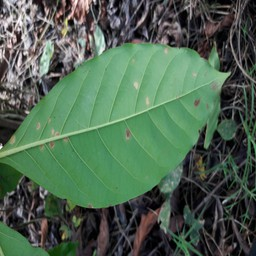

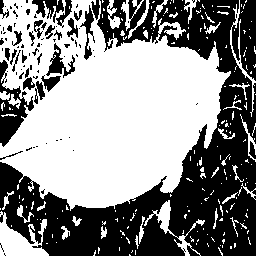

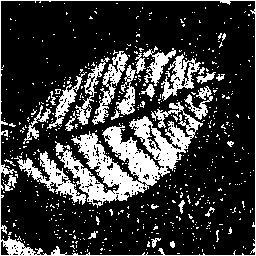

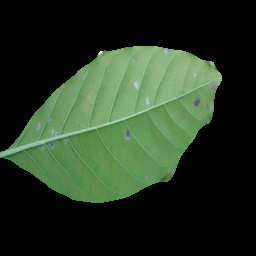